<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/main/Baseline_CNN_224dpi_5reps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
from datetime import datetime
import time
import csv

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import tensorflow as tf
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split


In [2]:
# Parameters of the images
SIZE = 224 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

#Parameterf of the CNN
Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
num_classes = 2  # Number of clases for prediction

#Parameters of the test-val split
TEST_SIZE = 0.3   # Validation/Train split ratio
RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

### Set up GDrive for images and custom module

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Import custom module with helper functions
import sys
sys.path.append('/content/drive/My Drive')
import funcs as f

# Unzip archives with images
!unzip -q "/content/drive/My Drive/224_nothresh.zip" -d "/content"
!unzip -q "/content/drive/My Drive/224.zip" -d "/content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read images and visualize a sample

In [4]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}')

X_files , y = f.read_names(input_dir)
print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 300 images with bacteria and 3479 without


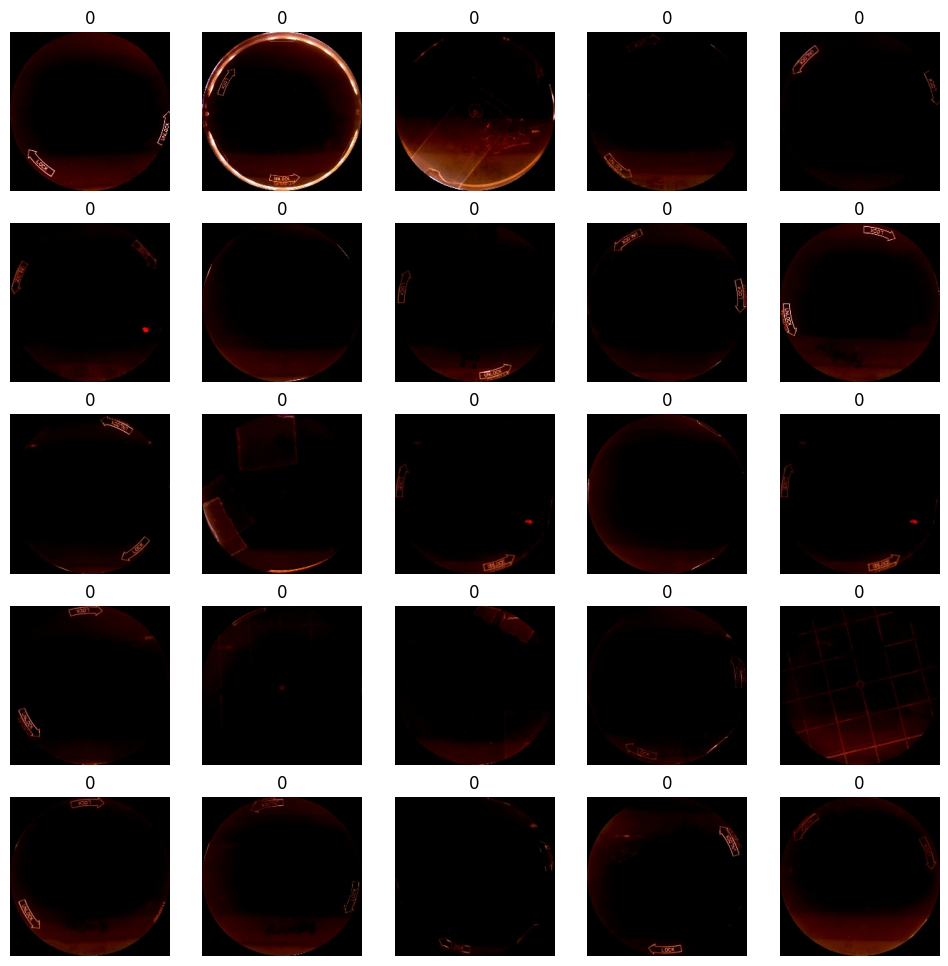

In [5]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    file = os.path.join(input_dir, X_files[idx])
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

### Make and train the model

In [6]:
def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (3, 3), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (5, 5), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (5, 5), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(512, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers

early_stopping = f.CustomStopper()

In [8]:
# Train model predefined number of times, increasing the random seed every time
# Collect data on precision-recall curves for each model as well as history for each trianing run
for iter in range(5):
  print (f"Start iteration {iter}")
  # Get the names of the files that will be used for both thresholded and non-thresholded images
  X_train_names, X_val_names, y_train, y_val = f.custom_train_val_split(X_files, y, TEST_SIZE, RAND_SEED+iter)

  '''
  DO RAW DATASET FIRST
  '''

  # Read the actual files
  print("Reading images...")
  no_thr_dir = os.path.join(p, f'{SIZE}_nothresh')   #Set the folder where nonthreholded files live
  X_train = f.read_images(X_train_names, no_thr_dir)
  X_val = f.read_images(X_val_names, no_thr_dir)

  # Create a TensorFlow Dataset
  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  # Define and compile the CNN model
  conv_layers = make_conv_layers(INPUT_SHAPE)
  cnn_model = create_cnn_model(conv_layers, num_classes)
  cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model with the early stopping callback
  print("Training model...")
  start_time = time.time()
  cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = False, callbacks=[early_stopping])
  end_time = time.time()

  print(f"{iter}'th raw dataset training took {end_time - start_time:.2f} seconds")

  # Save results
  model_dir = os.path.join(p, "drive", "MyDrive", 'Baseline_CNN', f'{iter}_raw_model')
  result_dir = os.path.join(p, "drive", "MyDrive", 'Baseline_CNN')
  y_true = np.argmax(y_val, axis=1)
  y_pred = cnn_model.predict(X_val)
  thresholds = np.arange(0, 0.055, 0.0005)

  f.save_model_results(cnn_model, model_dir, X_val_names, 0.0005, y_true, y_pred, thresholds, cnn_history, result_dir, f'baseline224_raw_{iter}')

  '''
  REPEAT THE SAME FOR IMAGES WITH PRE_PROCESSING
  '''
  # Read the actual files
  print("Reading images...")
  preproc_dir = os.path.join(p, f'{SIZE}')   #Set the folder where threholded files live
  X_train_preproc = f.read_images(X_train_names, preproc_dir)
  X_val_preproc = f.read_images(X_val_names, preproc_dir)

  # Create a TensorFlow Dataset
  train_data = tf.data.Dataset.from_tensor_slices((X_train_preproc, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((X_val_preproc, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  # Define and compile the CNN model
  conv_layers = make_conv_layers(INPUT_SHAPE)
  cnn_model_preproc = create_cnn_model(conv_layers, num_classes)
  cnn_model_preproc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model with the early stopping callback
  print("Training model...")
  start_time = time.time()
  cnn_history_preproc = cnn_model_preproc.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = False, callbacks=[early_stopping])
  end_time = time.time()
  print(f"{iter}'th pre-procesed dataset training took {end_time - start_time:.2f} seconds")

  # Save results
  model_dir = os.path.join(p, "drive", "MyDrive", 'Baseline_CNN', f'{iter}_preproc_model')
  y_pred = cnn_model_preproc.predict(X_val_preproc)
  f.save_model_results(cnn_model_preproc, model_dir, X_val_names, 0.0005, y_true, y_pred, thresholds, cnn_history_preproc, result_dir, f'baseline224_preproc_{iter}')

  print (f"Done with iteration {iter}")


Start iteration 0
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
0'th raw dataset training took 511.05 seconds
36/36 [==============================] - 3s 70ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
0'th pre-procesed dataset training took 458.96 seconds
36/36 [==============================] - 4s 99ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Done with iteration 0
Start iteration 1
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
1'th raw dataset training took 593.09 seconds
36/36 [==============================] - 4s 103ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
1'th pre-procesed dataset training took 548.84 seconds
36/36 [==============================] - 4s 111ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Done with iteration 1
Start iteration 2
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
2'th raw dataset training took 590.03 seconds
36/36 [==============================] - 4s 119ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
2'th pre-procesed dataset training took 632.97 seconds
36/36 [==============================] - 4s 112ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Done with iteration 2
Start iteration 3
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
3'th raw dataset training took 560.29 seconds
36/36 [==============================] - 5s 143ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
3'th pre-procesed dataset training took 674.18 seconds
36/36 [==============================] - 5s 142ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Done with iteration 3
Start iteration 4
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
4'th raw dataset training took 574.72 seconds
36/36 [==============================] - 4s 110ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
4'th pre-procesed dataset training took 653.77 seconds
36/36 [==============================] - 5s 139ms/step
Saving model...


Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Done with iteration 4
